In [1]:
from data_processing import process_mat_file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from climate_extreme import ClimateExtreme
from climate_stats import plot_wet_days, plot_ECDF, plot_mean_and_std, calculate_monthly_stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
input_data_path = "/Users/cooper/Desktop/climate-impacts/data/Input_data.mat"
path_exp_first = '/Users/cooper/Desktop/climate-impacts/data/Exponential/Seperated_FirstOrder_Exp_1500(30).mat'

In [3]:
present_data = process_mat_file(input_data_path)
exp_first_data = process_mat_file(path_exp_first)

print(present_data.columns)

Index(['Precipitation', 'T_max', 'T_min', 'T_avg', 'Year', 'Month', 'Day'], dtype='object')


In [4]:
testing = calculate_monthly_stats(exp_first_data)
testing

,Year_,Month_,Precipitation_sum,Precipitation_mean,Precipitation_std,Precipitation_max,T_max_mean,T_max_std,T_min_mean,T_min_std,T_avg_mean,T_avg_std
0,1980,Jan,4046.617116,2.610721,5.338355,51.694624,2.714644,5.336287,-4.931444,4.939819,-1.108400,4.949307
1,1980,Feb,3533.533814,2.523953,4.859484,34.762838,3.158847,5.495976,-4.804825,4.856561,-0.822989,4.993436
2,1980,Mar,4184.205617,2.699487,5.429954,47.803005,5.654813,5.221131,-3.003548,4.187279,1.325633,4.509019
3,1980,Apr,4675.270285,3.116847,5.176193,35.661717,9.838557,5.274516,0.709580,3.824381,5.274068,4.379519
4,1980,May,6242.168929,4.027206,6.495380,54.472123,13.767649,5.309512,4.390631,3.560495,9.079140,4.273162
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2009,Aug,6817.582272,4.398440,7.312381,59.331152,19.173678,4.128588,9.718913,3.033340,14.446296,3.419626
356,2009,Sep,5394.554523,3.596370,6.683994,61.533692,15.912731,4.100691,7.018765,3.113613,11.465748,3.443623
357,2009,Oct,4724.665125,3.048171,5.688609,54.429378,11.205702,4.824198,2.959923,3.798426,7.082812,4.156149
358,2009,Nov,4066.911195,2.711274,5.695529,71.592810,7.258130,5.035152,-0.480727,4.255554,3.388701,4.480349


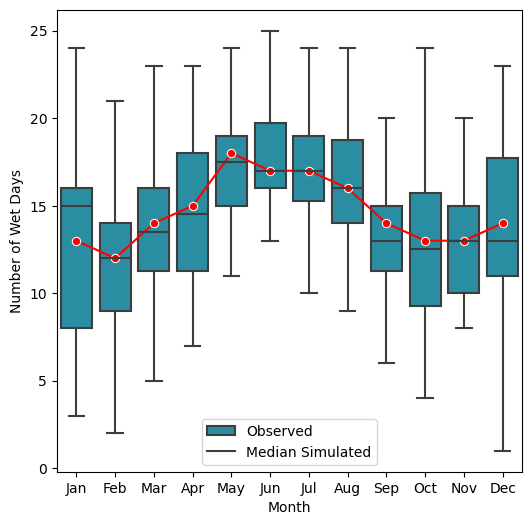

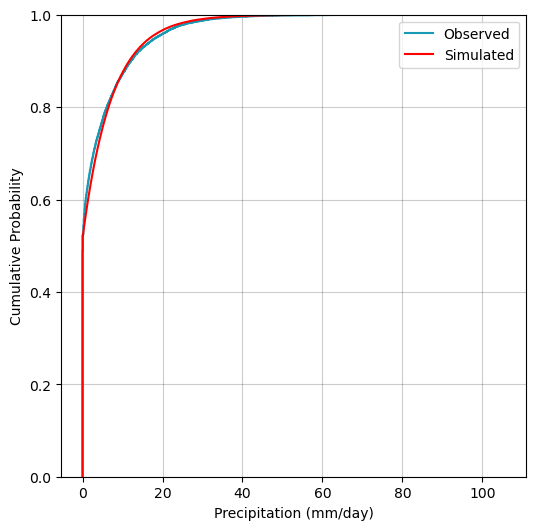

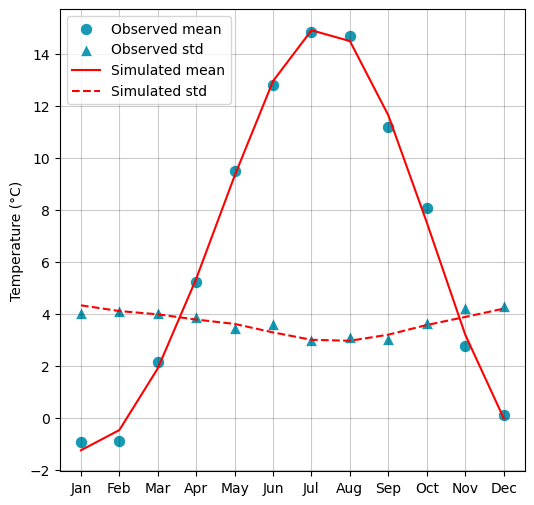

In [5]:
plot_wet_days(present_data, exp_first_data, '/Users/cooper/Desktop/climate-impacts/images/wet_days.png')
plot_ECDF(
    observations=present_data,
    simulation=exp_first_data,
    column="Precipitation",
    xlabel="Precipitation (mm/day)",
    output_destination='/Users/cooper/Desktop/climate-impacts/images/ECDF.png'
)

plot_mean_and_std(
    observations=present_data,
    simulation=exp_first_data,
    output_destination='/Users/cooper/Desktop/climate-impacts/images/mean_std.png')

In [6]:
present_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day,is_wet
0,0.4,1.5,-10.1,-4.30,1986,Jan,1,True
1,5.9,4.1,-2.0,1.05,1986,Jan,2,True
2,0.0,4.1,-3.1,0.50,1986,Jan,3,False
3,7.8,-0.3,-11.7,-6.00,1986,Jan,4,True
4,0.0,1.4,-10.1,-4.35,1986,Jan,5,False
...,...,...,...,...,...,...,...,...
12405,13.7,3.4,-1.1,1.15,2019,Dec,27,True
12406,0.4,2.2,-3.6,-0.70,2019,Dec,28,True
12407,0.0,5.7,-3.2,1.25,2019,Dec,29,False
12408,0.0,7.8,1.1,4.45,2019,Dec,30,False


In [7]:
exp_first_data

,Precipitation,T_max,T_min,T_avg,Year,Month,Day,Simulation,is_wet
0,1.052159,0.575836,-3.966348,-1.695256,1980,Jan,1,1,True
1,2.840043,2.131566,-2.196253,-0.032343,1980,Jan,2,1,True
2,0.000000,0.337740,-2.734396,-1.198328,1980,Jan,3,1,False
3,0.000000,4.614041,0.185355,2.399698,1980,Jan,4,1,False
4,2.044771,2.277004,-3.072299,-0.397647,1980,Jan,5,1,True
...,...,...,...,...,...,...,...,...,...
547495,13.138856,-2.289081,-9.061114,-5.675098,2009,Dec,27,50,True
547496,7.726682,-2.705927,-8.001282,-5.353604,2009,Dec,28,50,True
547497,5.920434,-0.570781,-7.474422,-4.022602,2009,Dec,29,50,True
547498,0.000000,1.047279,-5.964266,-2.458494,2009,Dec,30,50,False


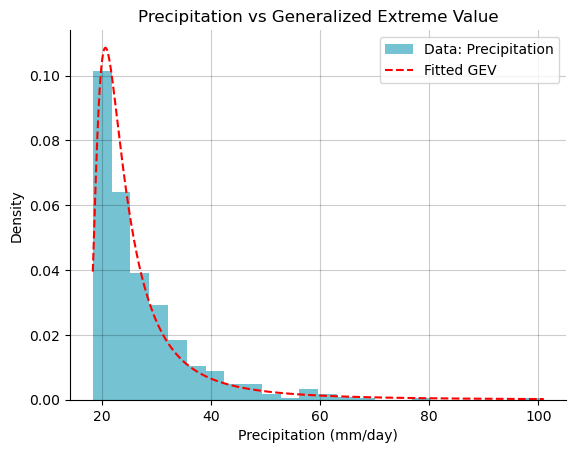

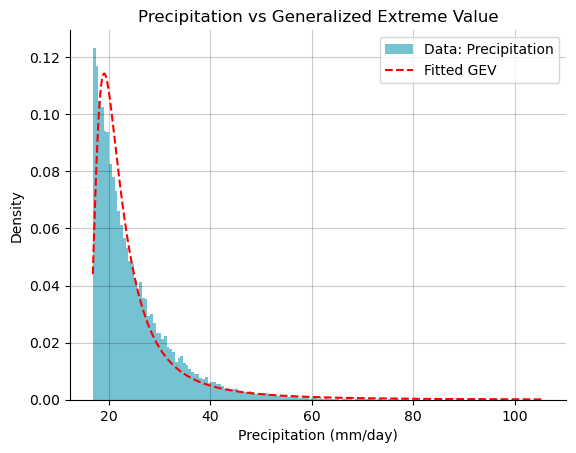

,Present,Exp_First,percent_change
c,-0.530303,-0.490934,-7.423897
loc,22.161532,20.438750,-7.773749
scale,3.823345,3.573868,-6.525097


In [8]:
present_stats = ClimateExtreme(present_data)
c, loc, scale = present_stats.fit_genextreme('Precipitation', 0.95)
present_stats.plot_hist_vs_genextreme('Precipitation', c=c, loc=loc, scale=scale, units='mm/day')

exp_first_stats = ClimateExtreme(exp_first_data)
c, loc, scale = exp_first_stats.fit_genextreme('Precipitation', 0.95)
exp_first_stats.plot_hist_vs_genextreme('Precipitation', c=c, loc=loc, scale=scale, units='mm/day')

params = ClimateExtreme.compare_parameters(stats1=present_stats,
                                        name1='Present',
                                        stats2=exp_first_stats,
                                        name2='Exp_First',
                                        distribution='genextreme',
                                        column='Precipitation')
params



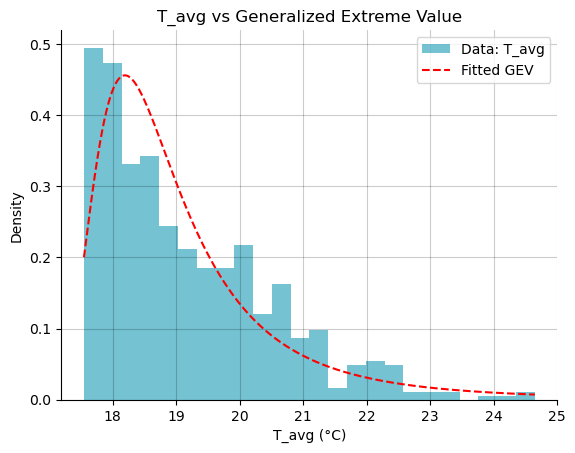

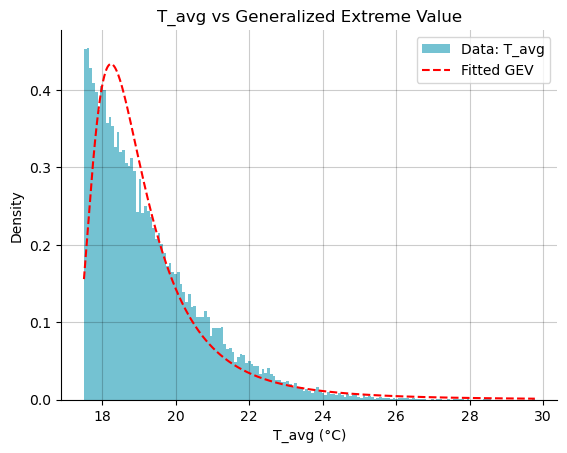

,Present,Exp_First,percent_change
c,-0.293315,-0.293679,0.124270
loc,18.402781,18.456316,0.290907
scale,0.838588,0.883301,5.331899


In [9]:
c, loc, scale = present_stats.fit_genextreme('T_avg', 0.95)
present_stats.plot_hist_vs_genextreme('T_avg', c=c, loc=loc, scale=scale, units='°C')

c, loc, scale = exp_first_stats.fit_genextreme('T_avg', 0.95)
exp_first_stats.plot_hist_vs_genextreme('T_avg', c=c, loc=loc, scale=scale, units='°C')

params = ClimateExtreme.compare_parameters(stats1=present_stats,
                                        name1='Present',
                                        stats2=exp_first_stats,
                                        name2='Exp_First',
                                        distribution='genextreme',
                                        column='T_avg')
params

In [10]:
present_stats.fit_results

{'Precipitation': {'distribution': 'genextreme',
  'parameters': {'c': -0.5303034848049583,
   'loc': 22.161531890087907,
   'scale': 3.8233450795820665}},
 'T_avg': {'distribution': 'genextreme',
  'parameters': {'c': -0.29331493002295694,
   'loc': 18.402781043093963,
   'scale': 0.838587924745368}}}